In [44]:
# %matplotlib nbagg
# %matplotlib inline
import sys
import os
import time
from datetime import datetime

sys.path.append("..")
# 自分のpath
os.chdir("/home/nakamura/HAI/main_server/hai")

import pymongo
from PIL import Image
from matplotlib import pylab as plt
from matplotlib.animation import ArtistAnimation
import matplotlib.animation as animation
import numpy as np
from bson.objectid import ObjectId
from sklearn.decomposition import PCA

from _app import app
from database import mongo
from notebooks.utils.utils import visualize, display_latest_image, display_image, print_time, strtime_to_epoch, epoch_to_strtime

In [2]:
app.config['PORT_DB']

20202

In [56]:
start = '2017-11-01 16:00:07'
end = '2017-11-01 18:16:56'
st = strtime_to_epoch(start)
et = strtime_to_epoch(end)

images0 = mongo.images.find({'time': {"$gt": st, "$lt": et}, "cam_id": "webcam0"}, sort=[("_id", pymongo.ASCENDING)])
images1 = mongo.images.find({'time': {"$gt": st, "$lt": et}, "cam_id": "webcam1"}, sort=[("_id", pymongo.ASCENDING)])

In [57]:
print(images0.count(), images1.count())

1867 1867


In [58]:
data = []
# 高速化する
for im0  in images0:
    try:
        plt.imshow(Image.open(app.config['RAW_IMG_DIR'] + im0['filename']))
    except:
        continue
    
    images1_l = mongo.images.find({'time': {"$gt": im0['time']}, "cam_id": "webcam1"}, sort=[("_id", pymongo.ASCENDING)])
    while True:
        im1_l = images1_l.next()
        try:
            plt.imshow(Image.open(app.config['RAW_IMG_DIR'] + im1_l['filename']))
            break
        except:
            continue
            
    images1_e = mongo.images.find({'time': {"$lt": im0['time']}, "cam_id": "webcam1"}, sort=[("_id", pymongo.DESCENDING)])
    while True:
        im1_e = images1_e.next()
        try:
            plt.imshow(Image.open(app.config['RAW_IMG_DIR'] + im1_e['filename']))
            break
        except:
            continue
            
    if  im1_l['time'] - im0['time'] > im0['time'] - im1_e['time']:
        im1 = im1_e
    else:
        im1 = im1_l
    
    data.append([im0, im1])

In [59]:
len(data)

1866

<IPython.core.display.Javascript object>


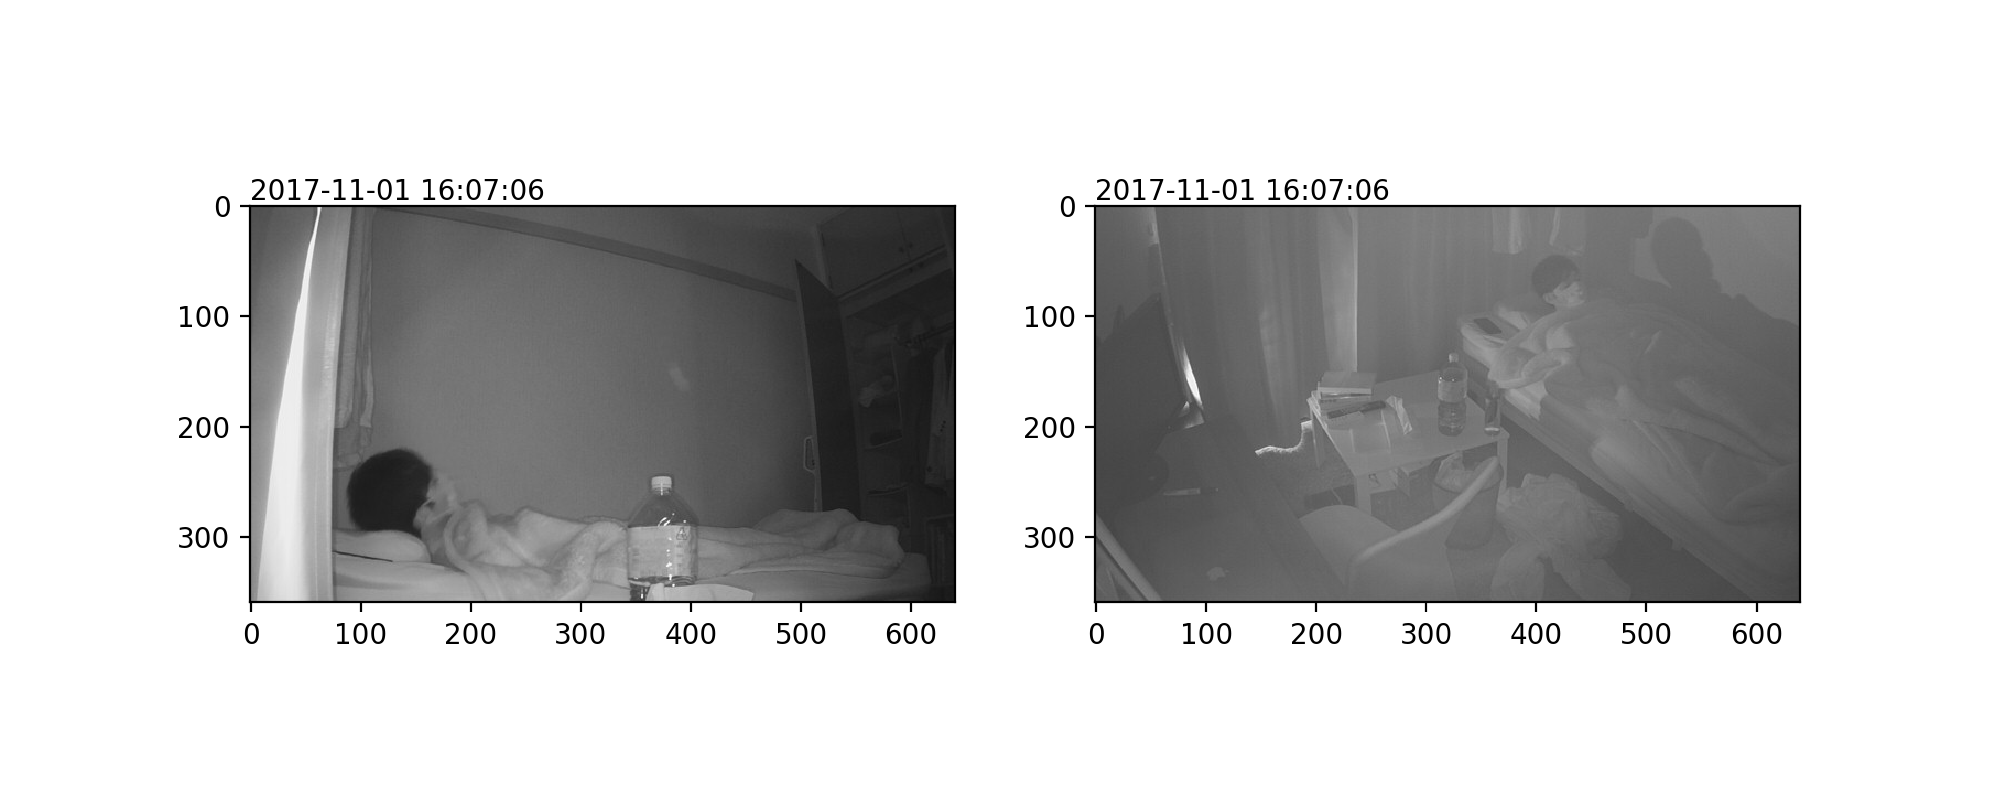

In [60]:
%matplotlib nbagg

num = len(data)
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.set_xticklabels([]) 
axR.set_xticklabels([]) 
axL.set_yticklabels([]) 
axR.set_yticklabels([]) 
axL.grid(False)
axR.grid(False)


def update_plot(i):
    axR.clear()
    im0 = data[i][0]
    im0_path = app.config['RAW_IMG_DIR'] + im0['filename']
    img0 = Image.open(im0_path, 'r')
    axR.imshow(img0)
    axR.text(0, 1.0, epoch_to_strtime(im0['time']),
             horizontalalignment='left',verticalalignment='bottom', transform=axR.transAxes)
    
    axL.clear()
    im1 = data[i][1]
    im1_path = app.config['RAW_IMG_DIR'] + im1['filename']
    img1 = Image.open(im1_path, 'r')
    axL.imshow(img1)
    axL.text(0, 1.0, epoch_to_strtime(im1['time']),
             horizontalalignment='left',verticalalignment='bottom', transform=axL.transAxes)
    
    return axL, axR


update_plot(0)
ani = animation.FuncAnimation(fig, update_plot, frames=range(num), interval=100)
# ani.save('data1102.mp4', writer="ffmpeg")
# fig.show()

In [95]:
# 0: 勉強
# 1: くつろぎ
# 2: 就寝
def get_huelabel(t):
    if t < strtime_to_epoch('2017-11-01 16:05:44'):
        return 0
    elif t < strtime_to_epoch('2017-11-01 16:06:44'):
        return 1
    elif t < strtime_to_epoch('2017-11-01 16:52:29'):
        return 2
    elif t < strtime_to_epoch('2017-11-01 16:57:15'):
        return 1
    elif t < strtime_to_epoch('2017-11-01 17:19:15'):
        return 2
    elif t < strtime_to_epoch('2017-11-01 17:38:38'):
        return 1
    elif t < strtime_to_epoch('2017-11-01 18:10:44'):
        return 0
    elif t < strtime_to_epoch('2017-11-01 18:14:12'):
        return 1
    else:
        return 2

In [118]:
X = []
Y = []
for d in data:
    if ('people' in d[0]['keypoints']) and (len(d[0]['keypoints']['people']) == 1):
        a = np.array(d[0]['keypoints']['people'][0]['pose_keypoints'])
    else:
        a = np.zeros(54)
        
    if ('people' in d[1]['keypoints']) and (len(d[1]['keypoints']['people']) == 1):
        b = np.array(d[1]['keypoints']['people'][0]['pose_keypoints'])
    else:
        b = np.zeros(54)
    
    X.append(np.concatenate((a, b)))
    Y.append(get_huelabel(d[0]['time']))
        
    

In [119]:
# PCAで2次元に次元削減
pca = PCA(n_components=2)
pca.fit(np.array(X))
X_2d = pca.fit_transform(np.array(X))

In [124]:
X_2d[0]

array([ 172.55162148, -473.48753862])

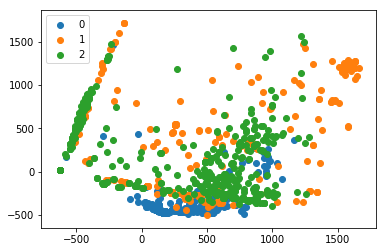

In [127]:
%matplotlib inline
for yl in set(Y):
    indices = [y == yl  for y in Y]
    points = X_2d[indices]
    plt.scatter(points[:, 0], points[:, 1], label=str(yl))
    
plt.legend()
plt.show()

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
clf = LogisticRegression()
cross_validation.cross_val_score(clf, X, Y, cv=5)

/home/nakamura/.pyenv/versions/anaconda3-4.4.0/envs/detection_server/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


array([ 0.76533333,  0.75935829,  0.65951743,  0.77688172,  0.80376344])

In [137]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=4)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.80455153949129854